## Fundamentals of Social Data Science
# Week 4 Day 1 Lab. Classification 

In this lab, you will be encouraged to explore your subreddits of choice using multinomial naive bayes and k-means classifications. Determine which one is more suitable using accuracy scores. Use both the TfIDFVectorizer and the CountVectorizer. 

Consider the use of stop words and lemmatisation. 

1. Plot the documents using t-SNE and then color the documents according the most accurate solution. 
2. For Naive Bayes report the 5 most informative terms per solution.  
* Would you be able to report the 5 most informative terms with k-means? This would be a bit far out for this lecture but if you are adventurous you can explore approaches like k-nearest neighbors using the centroids (as in report the 5 nearest neighbors to the centroid for each of the k solutions). 

There is only limited example code for this exercise. It is up to you to stitch together what you have learned as well as potentially draw upon external sources. On Wednesday we will provide an example solution.

Some guidance: 
1. Transform your headlines into a list similar to the walkthrough: [("headline (and maybe selftext)", "subreddit_label"), ("next headline", "next subreddit_label")]
 * Create one long list for all three subreddits to send to the Vectorizer. This is different to what I showed in Week 3 Day 3 where we had a separate vectorizer for each subreddit. To help you out I've started some code that creates a DataFrame for all the subs. 
2. Consider your tokenization. Will you use stop words or not? 
3. Consider plotting the classification on t-SNE to get some intuitions for how the solution maps out visually. 
4. Remember, are you classifying the documents using the terms? Or classifying the terms using the documents? Be careful with how you set this up. Notice that in the examples in the walkthrough we were classifying the documents using the terms. 
5. Consider the structure of this repository. Will you want to place some code for a plotting function in the `analysis.py`? What about creating a function under `text_processor.py` to transform the reddit data into the data structure needed. You can do everything in this Jupyter lab notebook but you should use this opportunity to think about how you might make use of this structure in order to help keep your code tidy. 


In [1]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *

scraper = RedditScraper(USER_AGENT)
subs_of_interest = ['AmItheAsshole', 'confessions', 'tifu']

posts_list = []

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    df = create_posts_dataframe(posts)
    df['subreddit'] = sub
    posts_list.append(df)

posts_df = pd.concat(posts_list)
posts_df = posts_df.reset_index(drop=True)


Fetching posts from https://api.reddit.com/r/AmItheAsshole/new
Response keys: dict_keys(['kind', 'data'])
Fetching posts from https://api.reddit.com/r/confessions/new
Response keys: dict_keys(['kind', 'data'])
Fetching posts from https://api.reddit.com/r/tifu/new
Response keys: dict_keys(['kind', 'data'])


In [ ]:
# Naive Bayes Classifier

posts_df

# K-Means result: 

It seems too bad

In [19]:
# K-means Classifier 
from utils.analysis import *
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from collections import defaultdict

# Read csv files and merge
filenames = ["datasets/AmItheAsshole.csv", "datasets/confessions.csv", "datasets/tifu.csv"]
dfs = [pd.read_csv(filename) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

# Split the text and the their labels
corpus_text = data['selftext'].fillna('') 
corpus_labels = data['subreddit']

# Preprocess and text vectorize
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# K-means clustering
n_clusters = len(corpus_labels.unique())
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Map cluster numbers to labels
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

print("\nK-means Clustering Results:")
print(classification_report(corpus_labels, kmeans_pred))



K-means Clustering Results:
               precision    recall  f1-score   support

AmItheAsshole       0.64      0.54      0.58       500
  confessions       0.65      0.56      0.60       500
         tifu       0.56      0.72      0.63       500

     accuracy                           0.61      1500
    macro avg       0.61      0.61      0.60      1500
 weighted avg       0.61      0.61      0.60      1500



## Demonstration of K-Means Clustering

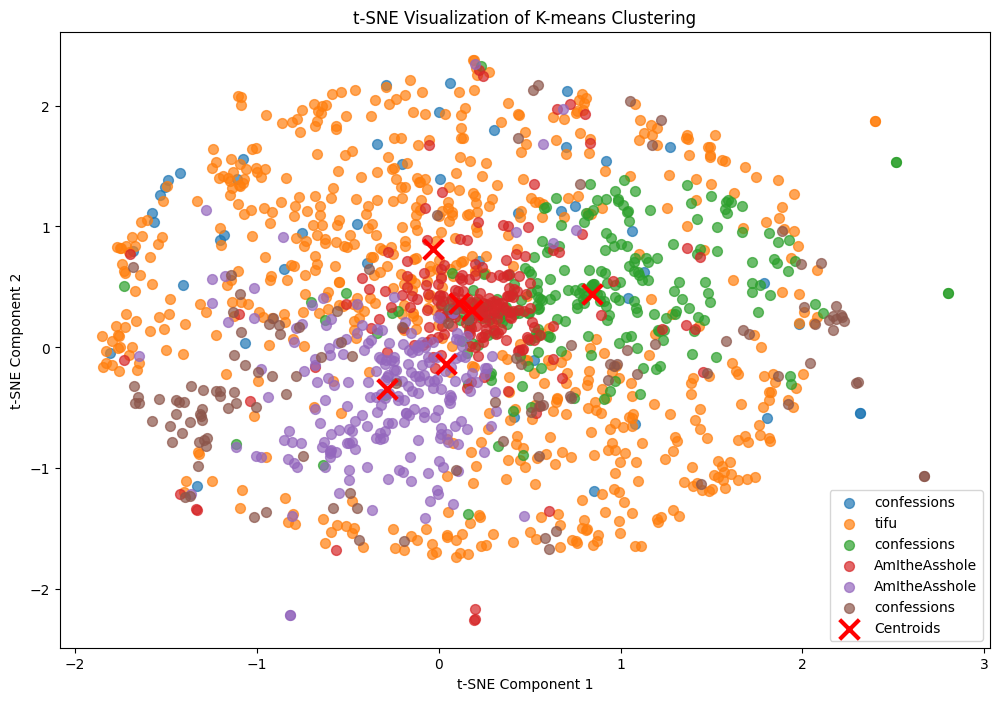

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))

unique_labels = np.unique(kmeans_labels)

for label in unique_labels:
    subreddit_name = cluster_to_label[label]  
    plt.scatter(
        X_tsne[kmeans_labels == label, 0], 
        X_tsne[kmeans_labels == label, 1], 
        label=f'{subreddit_name}', 
        s=50, 
        alpha=0.7
    )

centers_2d = np.array([X_tsne[kmeans_labels == label].mean(axis=0) for label in unique_labels])
plt.scatter(
    centers_2d[:, 0], 
    centers_2d[:, 1], 
    c='red', 
    marker='x', 
    s=200, 
    linewidth=3, 
    label='Centroids'
)

plt.title("t-SNE Visualization of K-means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


/var/folders/2b/c_5bbndx1zl1_7wqchywq1r00000gn/T/ipykernel_95941/1429654788.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(subreddits))
/var/folders/2b/c_5bbndx1zl1_7wqchywq1r00000gn/T/ipykernel_95941/1429654788.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


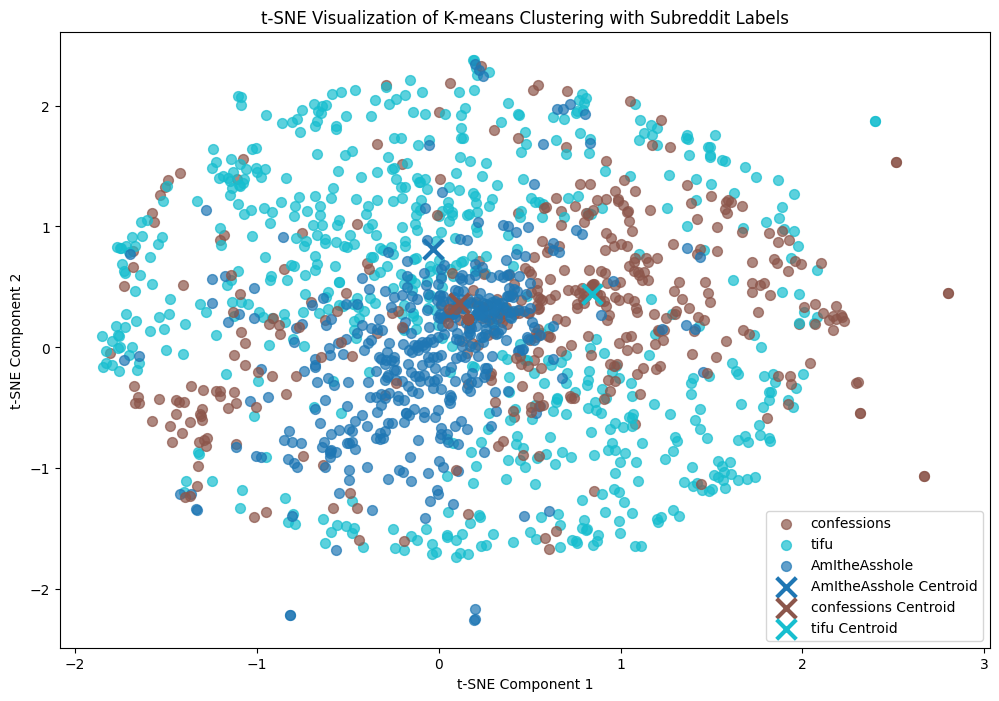

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))

unique_labels = np.unique(kmeans_labels)
subreddits = list(set(cluster_to_label.values()))
colors = plt.cm.get_cmap('tab10', len(subreddits))

plotted_labels = set()
for label in unique_labels:
    subreddit_name = cluster_to_label[label]
    color_idx = subreddits.index(subreddit_name) 
    
    if subreddit_name not in plotted_labels:
        plt.scatter(
            X_tsne[kmeans_labels == label, 0], 
            X_tsne[kmeans_labels == label, 1], 
            label=subreddit_name, 
            color=[colors(color_idx)], 
            s=50, 
            alpha=0.7
        )
        plotted_labels.add(subreddit_name)
    else:
        plt.scatter(
            X_tsne[kmeans_labels == label, 0], 
            X_tsne[kmeans_labels == label, 1], 
            color=[colors(color_idx)], 
            s=50, 
            alpha=0.7
        )


centers_2d = np.array([X_tsne[kmeans_labels == label].mean(axis=0) for label in unique_labels])
for idx, subreddit_name in enumerate(subreddits):
    plt.scatter(
        centers_2d[idx, 0], 
        centers_2d[idx, 1], 
        c=colors(idx), 
        marker='x', 
        s=200, 
        linewidth=3, 
        label=f'{subreddit_name} Centroid'
    )

plt.title("t-SNE Visualization of K-means Clustering with Subreddit Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


/var/folders/2b/c_5bbndx1zl1_7wqchywq1r00000gn/T/ipykernel_95941/3993450448.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


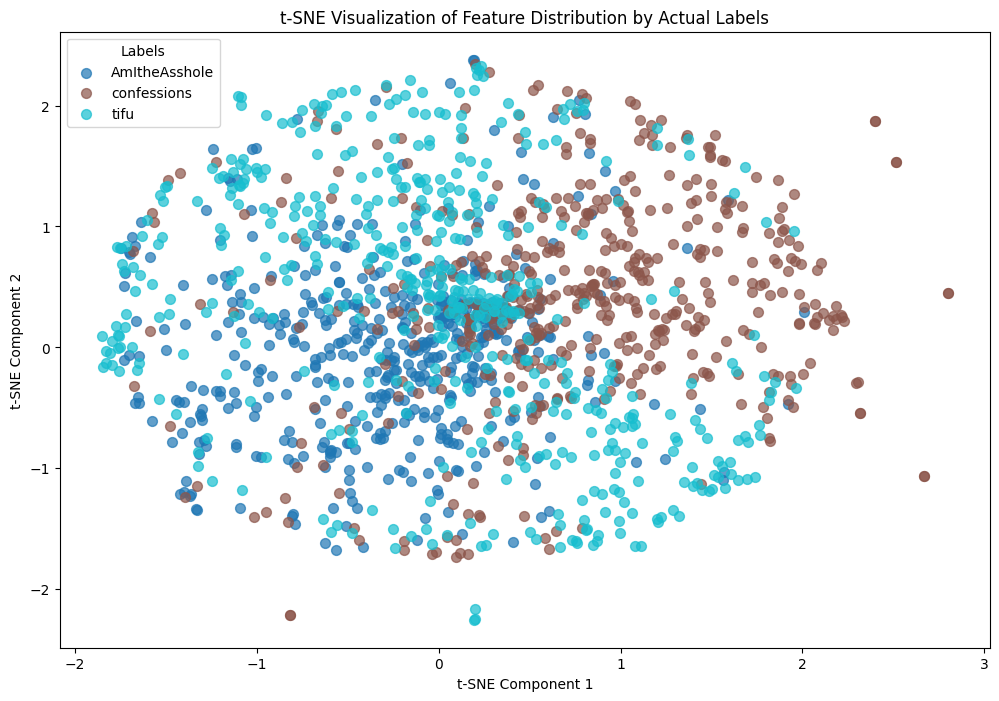

In [23]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))
unique_labels = corpus_labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = corpus_labels == label
    plt.scatter(reduced_vectors[idx, 0], reduced_vectors[idx, 1], 
                label=label, s=50, alpha=0.7, c=[colors(i)], marker='o')

plt.title("t-SNE Visualization of Feature Distribution by Actual Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Labels")
plt.show()

## K-Means in two_clusters

In [16]:
# K-means Classifier 
from utils.analysis import *
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from collections import defaultdict

# Read csv files and merge
filenames = ["datasets/AmItheAsshole.csv", "datasets/confessions.csv"]
dfs = [pd.read_csv(filename) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

# Split the text and the their labels
corpus_text = data['selftext'].fillna('') 
corpus_labels = data['subreddit']

# Preprocess and text vectorize
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# K-means clustering
n_clusters = len(corpus_labels.unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Map cluster numbers to labels
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

print("\nK-means Clustering Results:")
print(classification_report(corpus_labels, kmeans_pred))



K-means Clustering Results:
               precision    recall  f1-score   support

AmItheAsshole       0.56      0.70      0.62       500
  confessions       0.60      0.45      0.51       500

     accuracy                           0.57      1000
    macro avg       0.58      0.57      0.57      1000
 weighted avg       0.58      0.57      0.57      1000



In [17]:
# K-means Classifier 
from utils.analysis import *
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from collections import defaultdict

# Read csv files and merge
filenames = ["datasets/AmItheAsshole.csv", "datasets/tifu.csv"]
dfs = [pd.read_csv(filename) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

# Split the text and the their labels
corpus_text = data['selftext'].fillna('') 
corpus_labels = data['subreddit']

# Preprocess and text vectorize
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# K-means clustering
n_clusters = len(corpus_labels.unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Map cluster numbers to labels
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

print("\nK-means Clustering Results:")
print(classification_report(corpus_labels, kmeans_pred))



K-means Clustering Results:
               precision    recall  f1-score   support

AmItheAsshole       0.87      0.50      0.64       500
         tifu       0.65      0.93      0.76       500

     accuracy                           0.71      1000
    macro avg       0.76      0.71      0.70      1000
 weighted avg       0.76      0.71      0.70      1000



In [18]:
# K-means Classifier 
from utils.analysis import *
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from collections import defaultdict

# Read csv files and merge
filenames = ["datasets/confessions.csv", "datasets/tifu.csv"]
dfs = [pd.read_csv(filename) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

# Split the text and the their labels
corpus_text = data['selftext'].fillna('') 
corpus_labels = data['subreddit']

# Preprocess and text vectorize
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]
vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# K-means clustering
n_clusters = len(corpus_labels.unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Map cluster numbers to labels
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

print("\nK-means Clustering Results:")
print(classification_report(corpus_labels, kmeans_pred))



K-means Clustering Results:
              precision    recall  f1-score   support

 confessions       0.73      0.52      0.60       500
        tifu       0.63      0.81      0.71       500

    accuracy                           0.66      1000
   macro avg       0.68      0.66      0.65      1000
weighted avg       0.68      0.66      0.65      1000



First K-Meams result

| Label           | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| AmItheAsshole   | 0.56      | 0.70   | 0.62     | 500     |
| Confessions     | 0.60      | 0.45   | 0.51     | 500     |
| **Accuracy**    |           |        | **0.57** | 1000    |
| **Macro Avg**   | 0.58      | 0.57   | 0.57     | 1000    |
| **Weighted Avg**| 0.58      | 0.57   | 0.57     | 1000    |

---
Second K-Meams result

| Label           | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| Confessions     | 0.73      | 0.52   | 0.60     | 500     |
| TIFU            | 0.63      | 0.81   | 0.71     | 500     |
| **Accuracy**    |           |        | **0.66** | 1000    |
| **Macro Avg**   | 0.68      | 0.66   | 0.65     | 1000    |
| **Weighted Avg**| 0.68      | 0.66   | 0.65     | 1000    |

---

Third K-Meams result

| Label           | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| AmItheAsshole   | 0.87      | 0.50   | 0.64     | 500     |
| TIFU            | 0.65      | 0.93   | 0.76     | 500     |
| **Accuracy**    |           |        | **0.71** | 1000    |
| **Macro Avg**   | 0.76      | 0.71   | 0.70     | 1000    |
| **Weighted Avg**| 0.76      | 0.71   | 0.70     | 1000    |


# Naive Bayes results:

Much better than K-Means

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Preprocess text
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]

vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    X, corpus_labels, test_size=0.3, random_state=42
)

# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
               precision    recall  f1-score   support

AmItheAsshole       0.67      0.95      0.79       148
  confessions       0.92      0.66      0.77       141
         tifu       0.84      0.73      0.78       161

     accuracy                           0.78       450
    macro avg       0.81      0.78      0.78       450
 weighted avg       0.81      0.78      0.78       450



In [ ]:
# Report most informative features
def most_informative_features(vectorizer, classifier, n=10):
    feature_names = vectorizer.get_feature_names_out()
    class_labels = classifier.classes_
    top_features = {}

    for i, class_label in enumerate(class_labels):
        top_indices = classifier.feature_log_prob_[i].argsort()[-n:][::-1]
        top_features[class_label] = [(feature_names[j], classifier.feature_log_prob_[i][j]) for j in top_indices]

    return top_features

top_features = most_informative_features(vectorizer, nbc, n=15)
print("\nTop Features per Class:")
for class_label, features in top_features.items():
    print(f"\nClass: {class_label}")
    for feature, log_prob in features:
        print(f"  {feature}: {np.exp(log_prob):.4f}")


Top Features per Class:

Class: AmItheAsshole
  said: 0.0013
  told: 0.0012
  just: 0.0011
  like: 0.0011
  don: 0.0011
  mom: 0.0010
  friend: 0.0010
  want: 0.0009
  time: 0.0009
  didn: 0.0009
  dad: 0.0009
  friends: 0.0009
  family: 0.0009
  got: 0.0009
  know: 0.0008

Class: confessions
  like: 0.0015
  just: 0.0014
  feel: 0.0011
  know: 0.0011
  don: 0.0011
  life: 0.0009
  want: 0.0009
  ve: 0.0009
  think: 0.0008
  time: 0.0008
  love: 0.0008
  really: 0.0007
  people: 0.0007
  day: 0.0007
  years: 0.0006

Class: tifu
  just: 0.0011
  like: 0.0010
  tl: 0.0009
  dr: 0.0009
  didn: 0.0008
  got: 0.0008
  time: 0.0008
  know: 0.0007
  ve: 0.0007
  don: 0.0007
  went: 0.0007
  did: 0.0007
  said: 0.0007
  thought: 0.0007
  going: 0.0007


In [27]:
terms = vectorizer.get_feature_names_out()
for i in range(6):
    center_terms = kmeans.cluster_centers_[i].argsort()[-10:] 
    print(f"Cluster {i} center terms: {[terms[ind] for ind in center_terms]}")


Cluster 0 center terms: ['like', 'white', 'leave', 'know', 'says', 'come', 'let', 'cash', 'title', 'just']
Cluster 1 center terms: ['know', 've', 'said', 'day', 'work', 'didn', 'time', 'got', 'like', 'just']
Cluster 2 center terms: ['love', 'think', 'life', 've', 'know', 'want', 'just', 'feel', 'don', 'like']
Cluster 3 center terms: ['time', 'got', 'know', 'didn', 'told', 'just', 'like', 'said', 'friends', 'friend']
Cluster 4 center terms: ['wife', 'just', 'said', 'told', 'parents', 'brother', 'sister', 'family', 'dad', 'mom']
Cluster 5 center terms: ['want', 'cock', 'just', 'party', 'horny', 'gift', 'said', 'college', 'money', 'birthday']


In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from utils.analysis import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


filenames = ["datasets/AmItheAsshole.csv", "datasets/confessions.csv", "datasets/tifu.csv"]
dfs = [pd.read_csv(filename) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

corpus_text = data['selftext'].fillna('') 
corpus_labels = data['subreddit']

preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]

nrc_lexicon = pd.read_csv("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", sep='\t', 
                          names=["word", "emotion", "association"])

emotion_dict = defaultdict(list)
for _, row in nrc_lexicon.iterrows():
    if row['association'] == 1:
        emotion_dict[row['word']].append(row['emotion'])


emotions = sorted(set(nrc_lexicon['emotion']))
emotion_vectors = []

for text in preprocessed_corpus:
    emotion_scores = {emotion: 0 for emotion in emotions}
    words = text.lower().split()
    for word in words:
        if word in emotion_dict:
            for emotion in emotion_dict[word]:
                emotion_scores[emotion] += 1
    emotion_vectors.append([emotion_scores[emotion] for emotion in emotions])


emotion_vectors_df = pd.DataFrame(emotion_vectors, columns=emotions)
scaler = StandardScaler()
X = scaler.fit_transform(emotion_vectors_df)

# X = emotion_vectors_df.values

# # Split data for NBC
# X_train, X_test, y_train, y_test = train_test_split(
#     X, corpus_labels, test_size=0.3, random_state=42
# )

# # Naive Bayes Classification
# nbc = MultinomialNB()
# nbc.fit(X_train, y_train)
# nbc_pred = nbc.predict(X_test)

# # Analyze results
# print("Naive Bayes Classification Results:")
# print(classification_report(y_test, nbc_pred))


n_clusters = len(corpus_labels.unique())  
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X)


# Map cluster numbers to labels
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

# Output the report
print("\nK-means Clustering Results (using Emotion Score Vectorization):")
print(classification_report(corpus_labels, kmeans_pred))



K-means Clustering Results (using Emotion Score Vectorization):
               precision    recall  f1-score   support

AmItheAsshole       0.47      0.63      0.54       500
  confessions       0.52      0.65      0.58       500
         tifu       0.46      0.20      0.28       500

     accuracy                           0.49      1500
    macro avg       0.49      0.49      0.47      1500
 weighted avg       0.49      0.49      0.47      1500



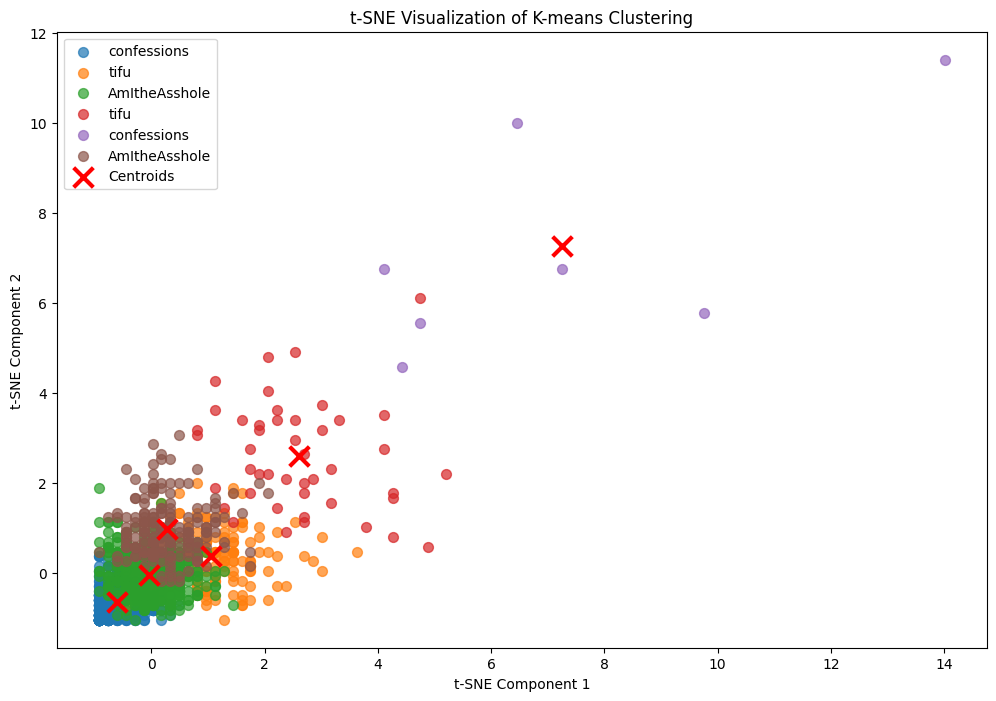

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)

plt.figure(figsize=(12, 8))

unique_labels = np.unique(kmeans_labels)

for label in unique_labels:
    subreddit_name = cluster_to_label[label]  
    plt.scatter(
        X[kmeans_labels == label, 0], 
        X[kmeans_labels == label, 1], 
        label=f'{subreddit_name}', 
        s=50, 
        alpha=0.7
    )

centers_2d = np.array([X[kmeans_labels == label].mean(axis=0) for label in unique_labels])
plt.scatter(
    centers_2d[:, 0], 
    centers_2d[:, 1], 
    c='red', 
    marker='x', 
    s=200, 
    linewidth=3, 
    label='Centroids'
)

plt.title("t-SNE Visualization of K-means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


/var/folders/2b/c_5bbndx1zl1_7wqchywq1r00000gn/T/ipykernel_95941/1069483128.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


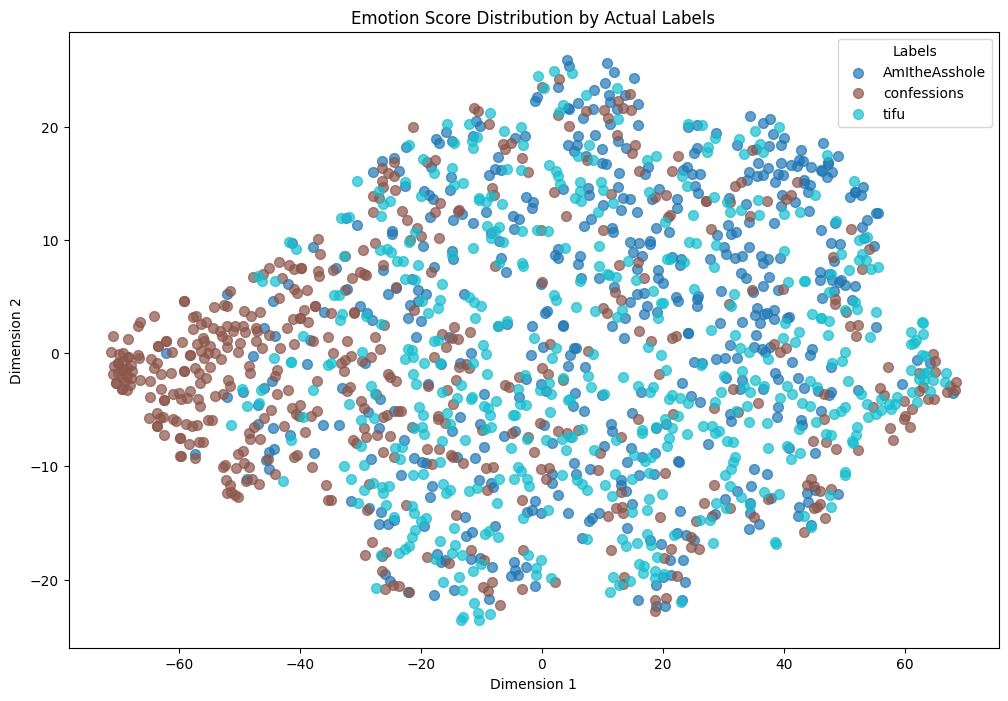

In [12]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(emotion_vectors_df)

# 绘制散点图
plt.figure(figsize=(12, 8))
unique_labels = corpus_labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = corpus_labels == label
    plt.scatter(reduced_vectors[idx, 0], reduced_vectors[idx, 1], 
                label=label, s=50, alpha=0.7, c=[colors(i)], marker='o')

plt.title("Emotion Score Distribution by Actual Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Labels")
plt.show()

Summarise k-Means results